# Top-down sampling and direct optimization 


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import hsv_to_rgb


##  Windy-Cliff-Walking Environment

In [2]:

max_steps =5

height = 4 #2*num_steps+1
width = 4 #2*num_steps+1
start = (height-1,0)#(num_steps,num_steps)
obj = (height-1,width-1)#(num_steps,2*num_steps-2)

num_states = width * height



In [3]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3

ACTIONS = ['UP', 'DOWN', 'RIGHT', 'LEFT']
num_actions = len(ACTIONS)

wind = [0 for _ in range(width)] # probability of being pushed down at column i 
# for now, without wind 
#wind[1],wind[2] = 0.2,0.2

In [4]:
class GridWorld:
    terrain_color = dict(normal=[127.0/360, 0.0, 96.0/100],                         
                         objective=[90.0/360, 90.0/100, 90.0/100],
                         cliff=[247.0/360, 92.0/100, 70.0/100],
                         player=[344.0/360, 93.0/100, 100.0/100])        
    def __init__(self):
        self.player = None
        self._create_grid()  
        self._draw_grid()
        
    def _create_grid(self, initial_grid=None):
        self.grid = self.terrain_color['normal'] * np.ones((height, width, 3))
        self._add_objectives(self.grid)
        
    def _add_objectives(self, grid,history = None):
        grid[start[0], start[1]:obj[1]] = self.terrain_color['cliff']

        grid[obj] = self.terrain_color['objective']
        grid[start] = self.terrain_color['player']
        if history is not None:
            for idx in history:
                grid[self._id_to_position(idx)] = self.terrain_color['player']
    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(width, height))
        self.ax.grid(which='minor')
        self.q_texts = [self.ax.text(*self._id_to_position(i)[::-1], s='0',
                                     fontsize=11, verticalalignment='center', 
                                     horizontalalignment='center') for i in range(height * width)]  
         
        self.im = self.ax.imshow(hsv_to_rgb(self.grid), cmap='terrain',
                                 interpolation='nearest', vmin=0, vmax=1)        
        self.ax.set_xticks(np.arange(width))
        self.ax.set_xticks(np.arange(width) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(height))
        self.ax.set_yticks(np.arange(height) - 0.5, minor=True)
        
    def reset(self):
        self.player = start      
        return self._position_to_id(self.player)
    
    def step(self,state, action):
        # Possible actions
        
        state = self._id_to_position(state)
        if action == 0 and state[0] > 0:
            state = (state[0] - 1, state[1])
        if action == 1 and state[0] < height - 1:
            state = (state[0] + 1, state[1])
        if action == 2 and state[1] < width - 1:
            state = (state[0], state[1] + 1)
        if action == 3 and state[1] > 0:
            state = (state[0], state[1] - 1)

        failed = all(self.grid[state] == self.terrain_color['cliff'])
        succeeded = all(self.grid[state] == self.terrain_color['objective'])
        
        if not (failed or succeeded):
            state = self._add_wind(state)
        
        # the wind can change his destiny :)
        failed = all(self.grid[state] == self.terrain_color['cliff'])
        succeeded = all(self.grid[state] == self.terrain_color['objective'])
        # Rules
        if failed:
            reward = -10
            status = 'failed'
        elif succeeded:
            reward = 10
            status = 'succeeded'          
        else:
            reward = -1
            status = 'walking'
            
        return self._position_to_id(state), reward, status
    
    def _add_wind(self,new_state):
        
        x_loc = new_state[1]
        p = np.random.random()
        if p<wind[x_loc] and new_state[0] < height-1:
            new_state = (new_state[0]+1, new_state[1])
        return new_state
            
    def _position_to_id(self, pos):
        ''' Maps a position in x,y coordinates to a unique ID '''
        return pos[0] * width + pos[1]
    
    def _id_to_position(self, idx):
        return (idx // width), (idx % width)
        
    def render(self, q_values=None, action=None,history = None, max_q=False, colorize_q=False):
        assert self.player is not None, 'You first need to call .reset()'  
        def change_range(values, vmin=0, vmax=1):
            start_zero = values - np.min(values)
            return (start_zero / (np.max(start_zero) + 1e-7)) * (vmax - vmin) + vmin 
        
        if colorize_q:
            assert q_values is not None, 'q_values must not be None for using colorize_q'            
            grid = self.terrain_color['normal'] * np.ones((height, width, 3))
            values = change_range(np.max(q_values, -1)).reshape(height, width)
            grid[:, :, 1] = values
            self._add_objectives(grid,history)
        else:            
            grid = self.grid.copy()
            
        grid[self.player] = self.terrain_color['player']       
        self.im.set_data(hsv_to_rgb(grid))
               
        if q_values is not None:
            xs = np.repeat(np.arange(width), height)
            ys = np.tile(np.arange(height), width)  
            
            for i, text in enumerate(self.q_texts):
                if max_q:
                    q = max(q_values[i])    
                    txt = '{:.2f}'.format(q)
                    text.set_text(txt)
                else:                
                    actions = ['U', 'D', 'R', 'L']
                    txt = '\n'.join(['{}: {:.2f}'.format(k, q) for k, q in zip(actions, q_values[i])])
                    text.set_text(txt)


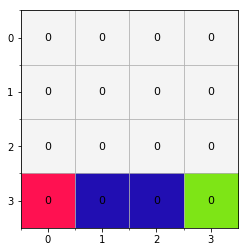

In [5]:
env = GridWorld()

## Policy model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import collections


In [7]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()       
        
        self.fc1 = nn.Linear(num_states,num_actions)
        
    def forward(self,state):
        #print state.size()
        state = torch.FloatTensor(state.size(0),num_states).zero_().scatter_(-1, state,1.0) # convert idx to 'one-hot'
        logits = self.fc1(state)
        
        return logits       

policy = Policy()


## Top-down construction 

In [8]:
def sample_gumbel(mu):
    """Sample a Gumbel(mu)."""    
    return -np.log(np.random.exponential()) + mu


def sample_truncated_gumbel(mu, b):
    """Sample a Gumbel(mu) truncated to be less than b."""    
    return -np.log(np.random.exponential() + np.exp(-b + mu)) + mu

  
def sample_gumbel_argmax(logits):
    """Sample from a softmax distribution over logits.

    TODO: check this is correct.

    Args:
    logits: A flat numpy array of logits.

    Returns:
    A sample from softmax(logits).
    """
    return np.argmax(-np.log(np.random.exponential(size=logits.shape)) + logits)


def logsumexp(logits):
    c = np.max(logits)
    return np.log(np.sum(np.exp(logits - c))) + c


def log_softmax(logits, axis=1):
    """Normalize logits per row so that they are logprobs.
  
      TODO: check this is correct. 
    """
    maxes = np.max(logits, axis=axis, keepdims=True)
    offset_logits = logits - maxes
    log_zs = np.log(np.sum(np.exp(offset_logits), axis=axis, keepdims=True))
    return offset_logits - log_zs

In [9]:
# Make a node without a state, and also don't allow `next_actions` to be None.
# Just put in all possible next actions when the node is created.
Node = collections.namedtuple('Node', 
                              [
                                  'prefix',
                                  'states',
                                  'reward_so_far',
                                  'status',                                  
                                  'logprob_so_far',
                                  'max_gumbel', 
                                  'next_actions',
                                  
                              ])

# Namedtuple for storing results
Trajectory = collections.namedtuple('Trajectory', ['actions','states','gumbel','reward','status'])


def sample_trajectory_gumbels(policy_model, num_actions,max_length=10,epsilon=1.0):
    """Samples an independent Gumbel(logprob) for each trajectory in top-down-ish order.

    Args:
        policy_model: Pytorch model that gets state and returns actions logits
        num_actions: Number of possible actions, should be equal to the policy output size
        max_length: Maximum length of a trajectory to allow.
        epsilon: direct optimization parameter
    Returns:
        y_opt: trajectory of max gumbel 
        y_direct: trajectory of max gumbel + reward*epsilon (target)
        final_trajectories: int, number of all trajectories (can be deleted, just for debugging)
    """

    # Start with a node for all trajectories.
    root_node = Node(prefix=[],
                   states = [env.reset()],
                   reward_so_far=0,
                   status='walking',  
                   logprob_so_far=0,
                   max_gumbel=sample_gumbel(0), 
                   next_actions=range(num_actions))
                   
    queue = [root_node]
    max_gumbel_eps_reward ,max_gumbel= -float('Inf'),-float('Inf')
    final_trajectories = []
    
    while queue:
        parent = queue.pop()
        if  len(parent.prefix) == max_length or parent.status in ['failed','succeeded'] :
            t = Trajectory(actions=parent.prefix,
                           states=parent.states,
                           gumbel=parent.max_gumbel,
                           reward=parent.reward_so_far,
                           status=parent.status)

            assert len(t.actions) == len(parent.states)-1
            final_trajectories.append(t)
            #computations for direct optimization
            gumbel_eps_reward = t.gumbel + epsilon*t.reward
            if gumbel_eps_reward > max_gumbel_eps_reward:
                max_gumbel_eps_reward = gumbel_eps_reward
                t_direct = t

            t_opt = t
            continue

        current_state = parent.states[-1]       
        
        with torch.no_grad():
            state = torch.LongTensor([current_state]).unsqueeze(0)
            action_logprobs = policy_model(state).numpy().squeeze(0)
        
        next_action_logprobs = action_logprobs[parent.next_actions]
        special_action_index = sample_gumbel_argmax(next_action_logprobs)
        special_action = parent.next_actions[special_action_index]
        special_action_logprob = action_logprobs[special_action]
        

        new_state,reward,status = env.step(current_state,special_action)

        special_child = Node(prefix=parent.prefix + [special_action],
                             states=parent.states + [new_state],
                             reward_so_far=parent.reward_so_far + reward,
                             status=status,
                             logprob_so_far=parent.logprob_so_far + special_action_logprob,
                             max_gumbel=parent.max_gumbel, 
                             next_actions=range(num_actions)) # All next actions are possible.

        queue.append(special_child)

        # Sample the max gumbel for the non-chosen actions and create an "other
        # children" node if there are any alternatives left.

        other_actions = [i for i in parent.next_actions if i != special_action]
        assert len(other_actions) == len(parent.next_actions) - 1

        if other_actions:
            other_max_location = logsumexp(action_logprobs[other_actions])
            other_max_gumbel = sample_truncated_gumbel(parent.logprob_so_far + other_max_location, 
                                                     parent.max_gumbel)
            other_children = Node(prefix=parent.prefix,
                                states=parent.states,
                                reward_so_far=parent.reward_so_far,
                                status=parent.status,
                                logprob_so_far=parent.logprob_so_far,
                                max_gumbel=other_max_gumbel,
                                next_actions=other_actions)



            queue.append(other_children)
            

    return t_opt, t_direct,final_trajectories #  final_trajectories is 

In [10]:

# example
t_opt, t_direct,final_trajectories = sample_trajectory_gumbels(policy,num_actions,max_steps)
print ('t_direct actions \n',t_direct.actions)
print ('t_opt actions \n',t_opt.actions)
print("Expected {} vs actual {}".format(num_actions**max_steps,
                                        len(final_trajectories)))

t_direct actions 
 [0, 2, 2, 2, 1]
t_opt actions 
 [2]
Expected 1024 vs actual 502


## Direct optimization 

In [11]:
def direct_optimization_loss(policy_model,t_opt,t_direct,epsilon=1.0):
    """computes \nabla \phi(a,s) = \sum_{t=1}^T \nabla \phi(a_t, s_t) with direct optimization
    
    Args:
        policy_model: Pytorch model gets state and returns actions logits 
        t_opt: trajectory with the max(gumbel)
        t_direct: trajectory with the max(gumbel+epsilon*reward) 
        epsilon: for direct optimization, usually between 0.9-1.0
    Returns: 
        logits multiplied with vector of (1,0,..,-1) [for example]
        so when we derive it with backward we ends up with \nabla \phi_opt(a,s) - \nabla \phi_direct(a,s)"""
    direct_states  = t_direct.states
    direct_states = torch.LongTensor(direct_states)[:-1].view(-1,1)
    opt_states  = t_opt.states
    opt_states = torch.LongTensor(opt_states)[:-1].view(-1,1)
    
    direct_actions = t_direct.actions
    direct_actions = torch.LongTensor(direct_actions).view(-1,1)
    opt_actions = t_opt.actions    
    opt_actions = torch.LongTensor(opt_actions).view(-1,1)
    
    opt_direct_states = torch.cat((opt_states,direct_states))
    
    phi = policy_model(opt_direct_states) # gets the logits so the network will calculates weights gradients

    #print phi
    y_direct = - torch.FloatTensor(direct_actions.size(0),phi.size(1)).zero_().scatter_(-1,direct_actions,1.0) # one-hot that points to the best direction
    y_opt = torch.FloatTensor(opt_actions.size(0),phi.size(1)).zero_().scatter_(-1, opt_actions,1.0)
    
    y_opt_direct = torch.cat((y_opt,y_direct))
    y_opt_direct = y_opt_direct*(1.0/epsilon)
    
    #print y_opt_direct*phi
    policy_loss = torch.sum(y_opt_direct*phi)   
    return policy_loss

## Training 

In [12]:
def get_k_direct_k_star(traj_list,t_direct):
    """
    - Sort trajectories by t_opt (phi+gumbel) and compute how far down t_direct and t* (trajectory with maximum reward) fall on the list.
    Returning these positions k_direct and k*.
    """
    sorted_traj = sorted(traj_list, key=lambda t: t.gumbel)
    t_star = max(traj_list, key=lambda t: t.reward)
    k_direct = sorted_traj.index(t_direct)
    k_star = sorted_traj.index(t_star)
    
    return [(k_direct,k_star),(sorted_traj[k_direct].gumbel,sorted_traj[k_star].gumbel)]



In [13]:

def run_episode(actions_list):
    """Interacts with the environment given actions """
    rewards = 0
    status = 'walking'
    success = False
    state = env.reset()
    for action in actions_list: 
        state, reward, status = env.step(state,action)
        if status=='succeeded':
            success = True
        rewards += reward
    return rewards,success

In [14]:
def train_policy_model(policy_model, num_episodes=500,epsilon=1.0):

    optimizer = optim.Adam(policy_model.parameters(), lr=0.05)
    success = 0
    rewards = []
    k_direct_star = []
    for episode in range(num_episodes):
        t_opt, t_direct,final_trajectories = sample_trajectory_gumbels(policy_model=policy_model
                                                                       ,num_actions=num_actions,
                                                                       max_length=max_steps,
                                                                       epsilon=epsilon)
        k_direct_star.append(get_k_direct_k_star(final_trajectories,t_direct))
        policy_loss = direct_optimization_loss(policy_model = policy_model,
                                               t_opt=t_opt,
                                               t_direct=t_direct,
                                               epsilon=epsilon)

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        trajectory_reward,suc = run_episode(t_opt.actions)
        success += suc
        rewards.append(trajectory_reward)
    return policy_model,success,rewards,k_direct_star


In [15]:
policy = Policy()
policy,num_success,_,k_direct_star = train_policy_model(policy,num_episodes=200,epsilon=1.0) #the policy gradient method needs much more episodes to converge
num_success # number of times the player has reached the goal

118

## Visualization

/Users/guy_l/.virtualenvs/pytorch3/lib/python3.7/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


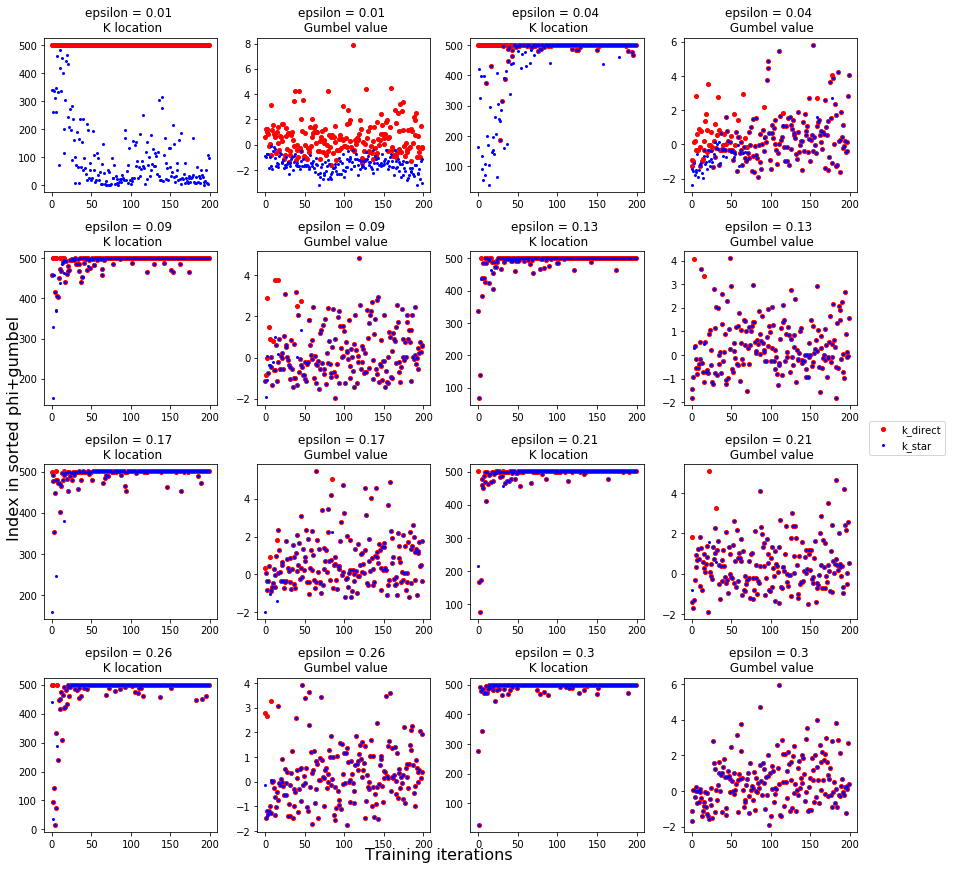

In [16]:
fig = plt.figure(figsize=(12, 12))
splots = 0
def visualize_k_direct_k_star(k_direct_star_list):
    global splots
    k_tuples,gumbel_tuples = zip(*k_direct_star_list)
    k_direct_list,k_star_list = zip(*k_tuples)
    gumbel_direct_list,gumbel_star_list = zip(*gumbel_tuples)
    
    ax = fig.add_subplot(4,4,splots)
    ax.plot(k_direct_list,'ro',markersize=4)
    ax.plot(k_star_list,'bo',markersize=2)
    ax.title.set_text('epsilon = '+str(eps) +' \n K location')
    splots += 1
    ax = fig.add_subplot(4,4,splots)
    ax.plot(gumbel_direct_list,'ro',markersize=4)
    ax.plot(gumbel_star_list,'bo',markersize=2)
    ax.title.set_text('epsilon = '+str(eps) +' \n Gumbel value')    

epsilons = np.around(np.linspace(0,0.3,8), decimals=2)
epsilons[0]=0.01
for eps in epsilons:
    policy = Policy()
    policy,num_success,rewards,k_direct_star = train_policy_model(policy,num_episodes=200,epsilon=eps)
    splots += 1
    visualize_k_direct_k_star(k_direct_star)
    
fig.legend(['k_direct','k_star'],loc='center left', bbox_to_anchor=(1, 0.5))
fig.text(0.5, 0, 'Training iterations', ha='center',fontsize=16)
fig.text(0, 0.5, 'Index in sorted phi+gumbel', va='center', rotation='vertical',fontsize=16)
fig.tight_layout()
fig.show()



Mean Reward: 0.8139999999999997


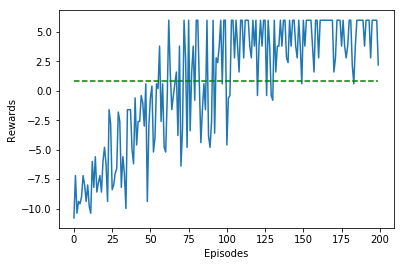

In [17]:
trials = 5
all_rewards =[]
for trial in range(trials):
    policy = Policy()
    policy,num_success,rewards,_ = train_policy_model(policy,num_episodes=200)
    all_rewards.append(rewards)
    
all_rewards = np.array(all_rewards)
avg_rewards = np.mean(all_rewards, axis=0)

mean_reward = [np.mean(avg_rewards)] * len(avg_rewards)
fig, ax = plt.subplots()
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.plot(avg_rewards)
ax.plot(mean_reward, 'g--')

print('Mean Reward: {}'.format(mean_reward[0]))

In [18]:
def fill_q_values(policy):
    q_values_pg = np.zeros((num_states, num_actions))

    for s in range(num_states):
        state = torch.LongTensor([s]).unsqueeze(0)
        q_values_pg[s] = F.softmax(policy(state),dim=-1).detach().numpy()
    return q_values_pg

In [19]:
def play(policy):
    t_direct,t_opt,_ = sample_trajectory_gumbels(policy,num_actions,max_steps)
    actions = t_direct.actions
    print ([ACTIONS[actions[i]] for i in range(len(actions))])
    env = GridWorld()
    state = env.reset()
    
    status = 'walking'
    history = [state]
    for action in actions:    
        # Select action
        # Do the action
        state, reward, status = env.step(state,action)
        history.append(state)

        env.player = env._id_to_position(state)
        #raw_input("Press Enter to continue...")
        env.render(q_values= fill_q_values(policy),history=history, colorize_q=True)
        #raw_input("Press Enter to continue...")
        if status == 'succeeded':
            return
    print ('path not found')

['UP', 'RIGHT', 'RIGHT', 'RIGHT', 'DOWN']


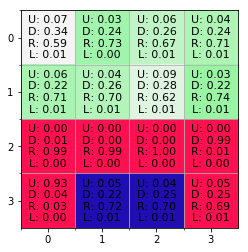

In [20]:
play(policy)